# DSC212 — Graph Theory Assignment  
## Modularity on the Karate Club Graph

**Student Name:** _Rachit Srivastava_  
**Roll Number / ID:** _IMS24180_  
**Course:** DSC212 — Graph Theory Assignment  

## 1. Introduction

**Zachary’s Karate Club** (34 members, 78 undirected friendship edges) is a canonical social network. During observation, a conflict between the club’s **instructor (Mr. Hi)** and **administrator (club president)** caused a fission into two factions. The pre-split friendship graph serves as a test case: can we detect incipient communities purely from network structure?

**Modularity** measures how much a partition’s within-community edges exceed what we would expect under a degree-preserving random null model. Maximizing modularity identifies community assignments that are statistically “more clustered than chance.”

This notebook implements the **spectral modularity** approach (Newman, 2006) with **recursive bisection** to find multiple communities and analyzes **node-level metrics** as the partition refines.


## 2. Implementation

In [1]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import deque
from copy import deepcopy
from dataclasses import dataclass


try:
    from scipy.linalg import eigh
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False


plt.rcParams['figure.dpi'] = 140
plt.rcParams['figure.figsize'] = (6, 5)
np.set_printoptions(precision=4, suppress=True)


### 2.1 Helper Functions: Modularity Matrix and Eigenpairs

In [2]:
def modularity_matrix(G, nodes=None):
    """Computing the modularity matrix B (full or restricted to `nodes`)."""
    if nodes is None:
        nodes = list(G.nodes())
    n = len(nodes)
    idx = {u:i for i,u in enumerate(nodes)}
   
    A = np.zeros((n,n), float)
    k = np.zeros(n, float)
    for i,u in enumerate(nodes):
        for v in G.neighbors(u):
            if v in idx:
                A[i, idx[v]] = 1.0
        k[i] = A[i].sum()
    m = G.number_of_edges()
    B = A - (np.outer(k, k) / (2.0*m))
    return B, nodes

def leading_eigenpair(B):
    """Return (lambda_max, eigenvector) for symmetric matrix B."""
    if B.size == 0:
        return 0.0, np.array([])
    if SCIPY_AVAILABLE:
        vals, vecs = eigh(B)  
    else:
        vals, vecs = np.linalg.eigh(B)
    i = np.argmax(vals)
    return float(vals[i]), vecs[:, i]


### 2.2 One-Step Spectral Bipartition on a Node Set

In [3]:
def spectral_bipartition(G, nodes):
    B, order = modularity_matrix(G, nodes)
    lam, vec = leading_eigenpair(B)
    if vec.size == 0:
        return dict(lambda_=lam, group_pos=list(nodes), group_neg=[], deltaQ=0.0, order=order)
    s = np.sign(vec).astype(float)  
    s[s==0] = -1.0                 
    pos = [order[i] for i in range(len(order)) if s[i] > 0]
    neg = [order[i] for i in range(len(order)) if s[i] < 0]
    m = G.number_of_edges()
    deltaQ = float((1.0/(4.0*m)) * (s @ (B @ s)))
    return dict(lambda_=lam, group_pos=pos, group_neg=neg, deltaQ=deltaQ, order=order)


### 2.3 Recursive Bisection with Eigenvalue Stopping Rule

In [4]:
@dataclass
class SplitRecord:
    communities: list
    bifurcated: tuple|None = None   
    eigenvalue: float|None = None
    deltaQ: float|None = None

def recursive_bisect(G, verbose=True):
    """Return a list of SplitRecord snapshots from start to final partition."""
    communities = [list(G.nodes())]
    records = [SplitRecord(communities=deepcopy(communities))]
    q = deque([0])
    while q:
        cidx = q.popleft()
        C = communities[cidx]
        if len(C) <= 1:
            continue
        info = spectral_bipartition(G, C)
        lam, dQ = info['lambda_'], info['deltaQ']
        if verbose:
            print(f"Consider community {cidx} (size {len(C)}): λ={lam:.6f}, ΔQ={dQ:.6f}")
        if lam <= 0:
            continue  
        Cpos, Cneg = info['group_pos'], info['group_neg']
        if len(Cpos)==0 or len(Cneg)==0:
            continue 
        communities[cidx] = Cpos
        communities.append(Cneg)
        records.append(SplitRecord(communities=deepcopy(communities),
                                   bifurcated=(cidx, (Cpos, Cneg)),
                                   eigenvalue=lam, deltaQ=dQ))
        q.append(cidx); q.append(len(communities)-1)
    return records


## 3. Visualization

In [5]:
def plot_partition(G, communities, pos=None, title=None):
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    fig, ax = plt.subplots()
    colors = plt.colormaps['tab20'].colors
    for i, C in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=C,
                               node_color=[colors[i % len(colors)]],
                               node_size=320, ax=ax, label=f'comm {i}')
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
    if title: ax.set_title(title)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02,1), fontsize='small')
    ax.axis('off')
    plt.show()
    return pos


## 4. Node Metrics and Their Evolution

In [6]:
def compute_metrics(G):
    return {
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'clustering': nx.clustering(G),
    }

def record_metrics_over_iterations(G, records):
    nodes = list(G.nodes())
    metric_names = ['degree','betweenness','closeness','clustering']
    history = {m:{n:[] for n in nodes} for m in metric_names}
    for rec in records:
        M = compute_metrics(G)  
        for m in metric_names:
            for n in nodes:
                history[m][n].append(M[m].get(n,0.0))
    return history

def plot_metric_evolution(history, metric_name, nodes_to_plot=None, figsize=(9,5)):
    nodes = sorted(history[metric_name].keys())
    iters = range(len(next(iter(history[metric_name].values()))))
    if nodes_to_plot is None:
        nodes_to_plot = nodes
    plt.figure(figsize=figsize)
    for n in nodes_to_plot:
        plt.plot(list(iters), history[metric_name][n], label=str(n))
    plt.xlabel('Iteration (split step)'); plt.ylabel(metric_name)
    plt.title(f'Evolution of {metric_name} across iterations')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
    plt.tight_layout(); plt.show()


## 5. Modularity of the Final Partition

In [7]:
def modularity_Q(G, communities):
    """Compute Q = (1/(2m)) sum_{i,j in same community} B_ij, using our B."""
    all_nodes = list(G.nodes())
    B, order = modularity_matrix(G, all_nodes)
    idx = {u:i for i,u in enumerate(order)}
    total = 0.0
    for C in communities:
        C_idx = [idx[u] for u in C]
        subB = B[np.ix_(C_idx, C_idx)]
        total += subB.sum()
    m = G.number_of_edges()
    return float(total / (2.0*m))


## 6. Results

Consider community 0 (size 34): λ=4.977080, ΔQ=0.371466
Consider community 0 (size 16): λ=3.403393, ΔQ=0.136506
Consider community 1 (size 18): λ=2.980825, ΔQ=0.103961
Consider community 0 (size 5): λ=2.289831, ΔQ=0.035503
Consider community 2 (size 11): λ=3.692296, ΔQ=0.103961
Consider community 1 (size 2): λ=0.987179, ΔQ=0.006328
Consider community 3 (size 16): λ=3.145140, ΔQ=0.118343

Total communities found: 4



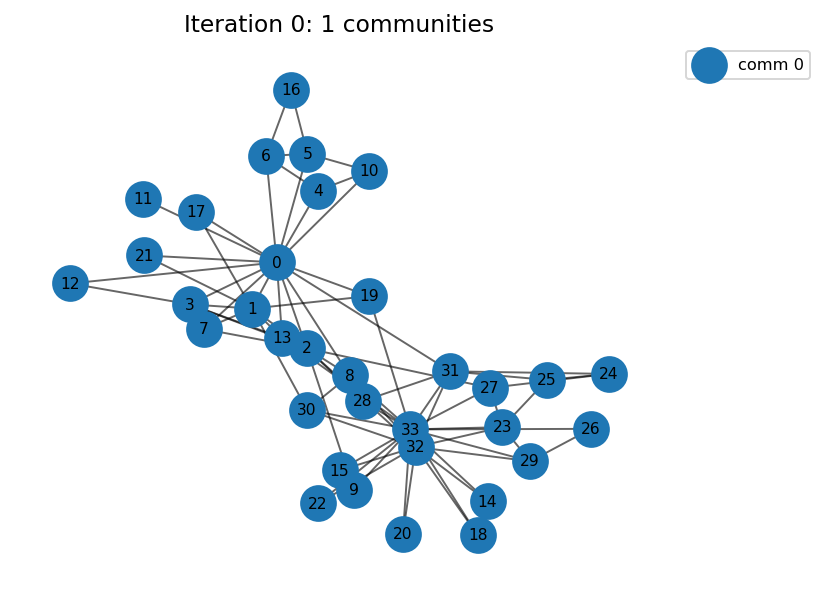

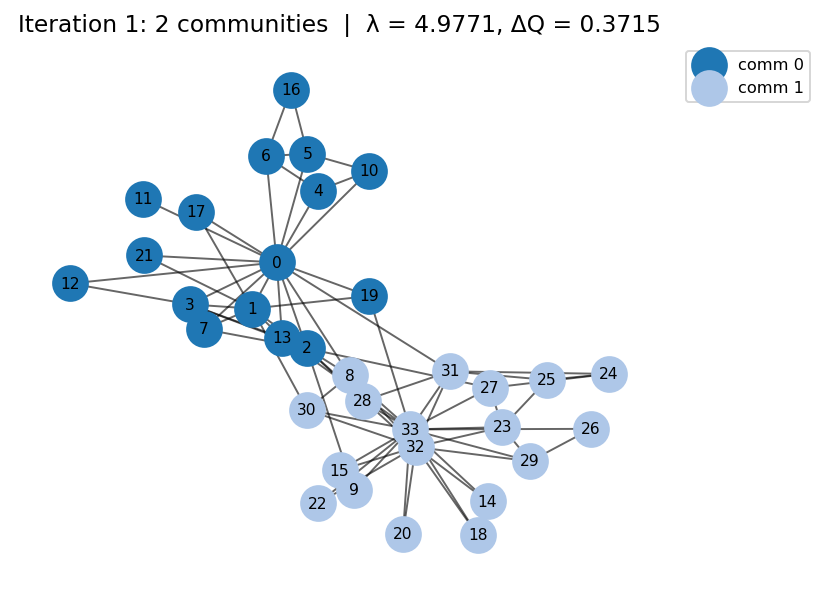

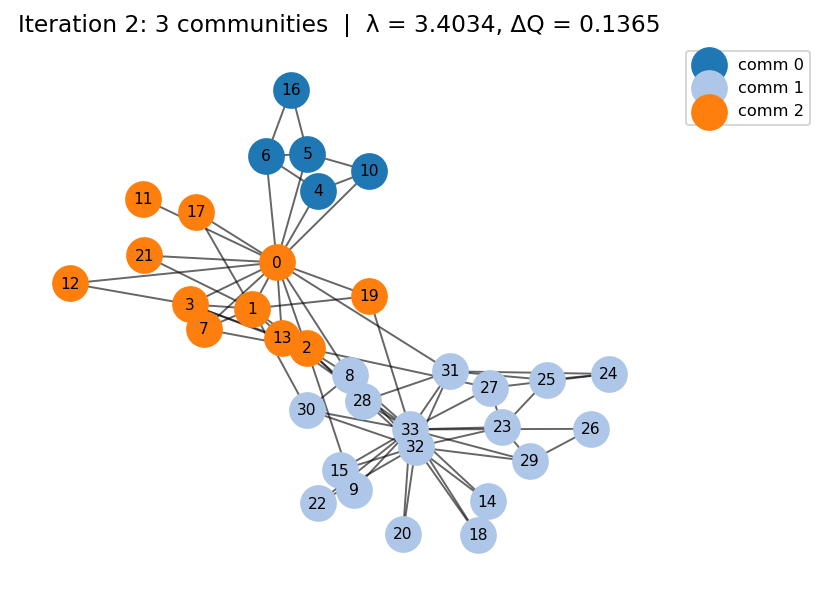

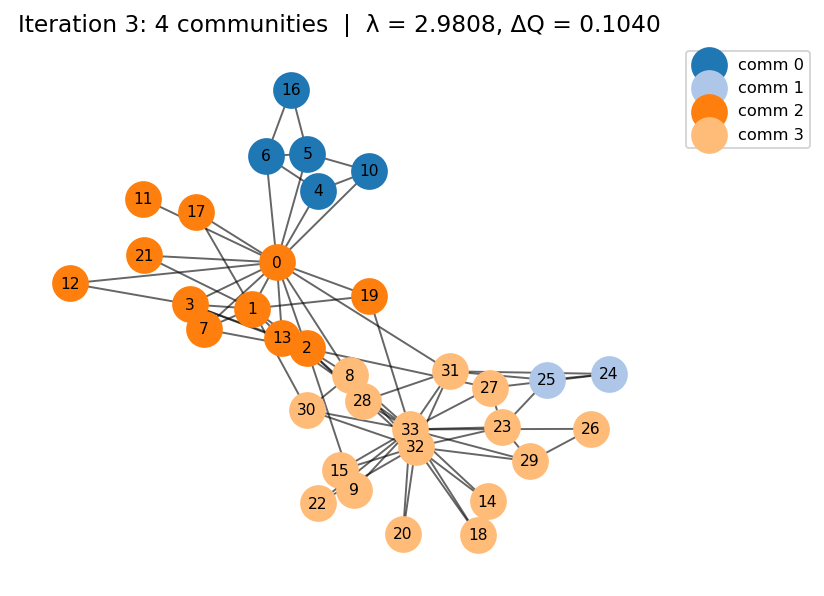

Top-degree nodes (for focused plotting): [33, 0, 32, 2, 1, 3]


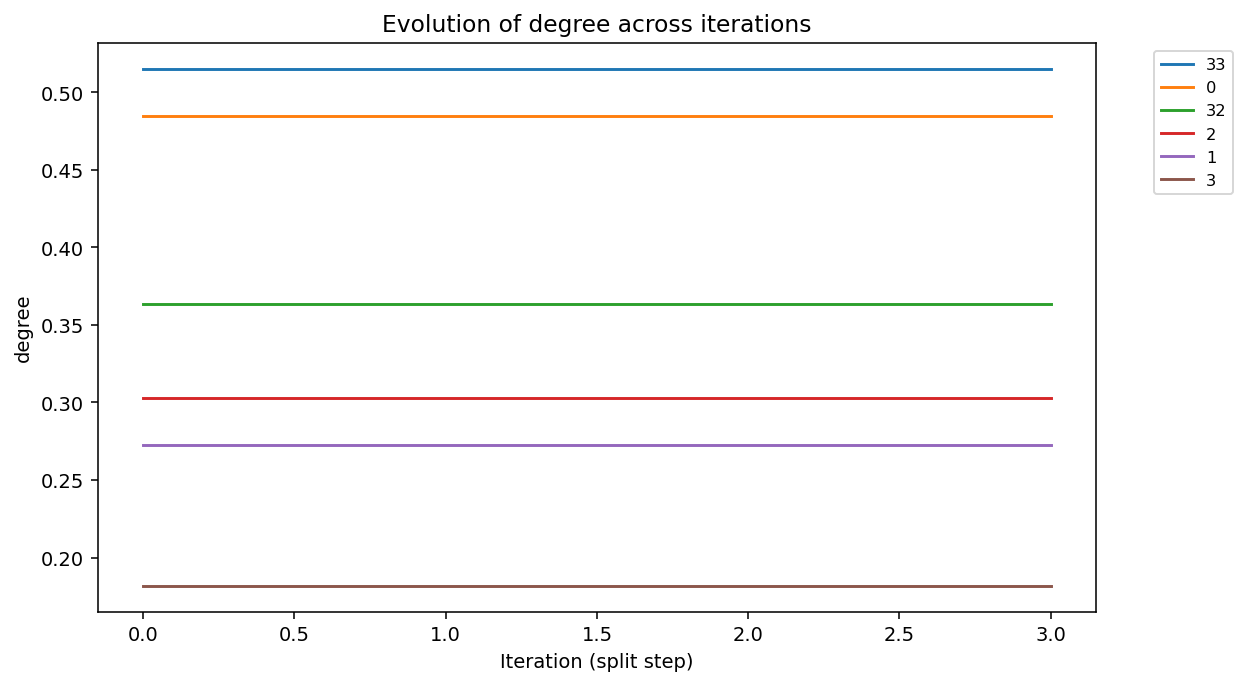

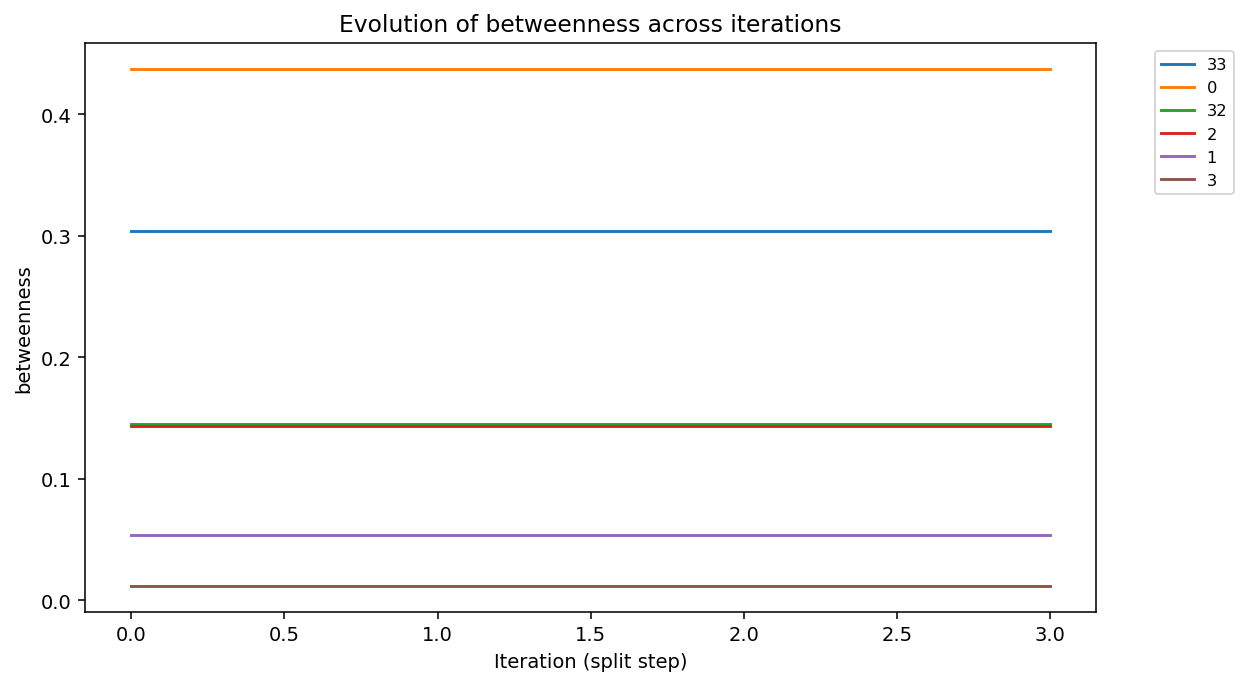

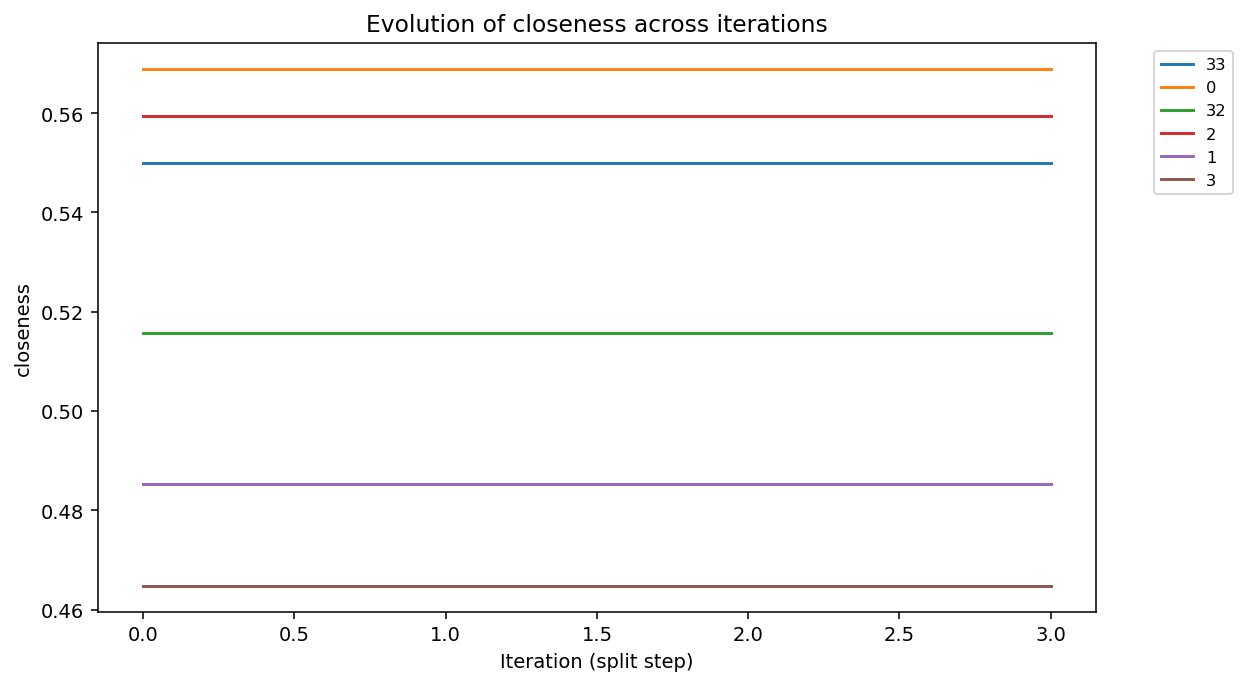

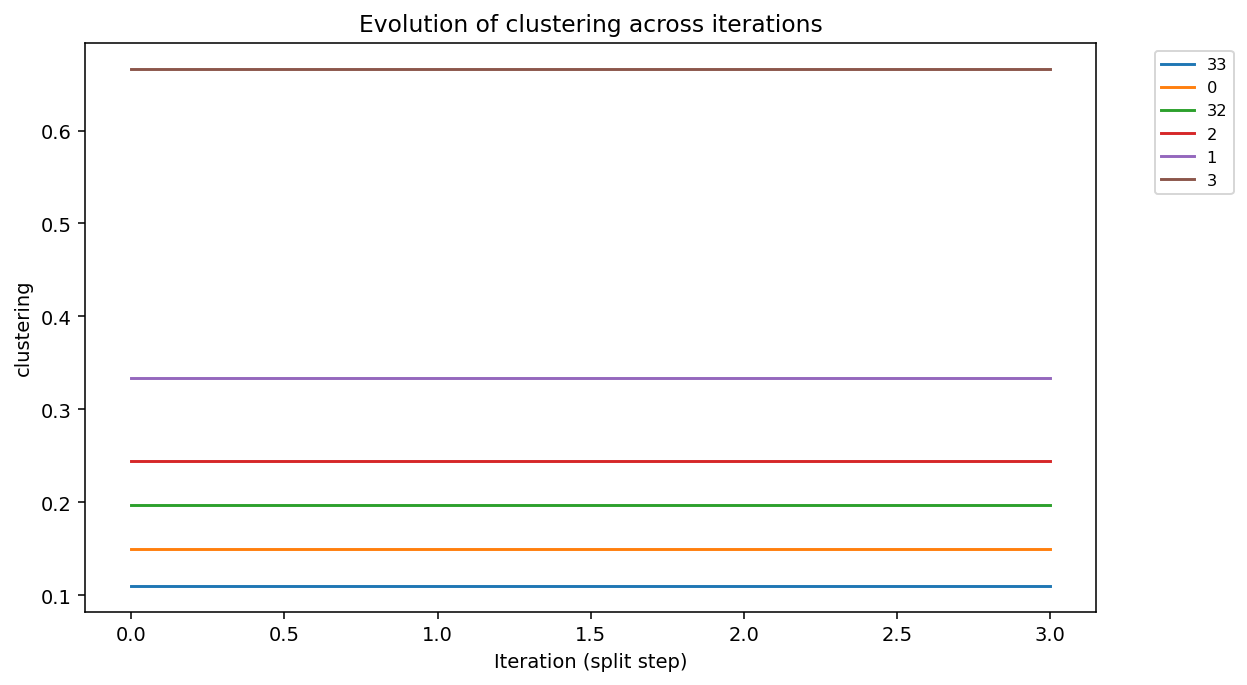

Computed modularity Q of final partition: 0.384287
NetworkX modularity() for final partition: 0.404415
Community 0 (size 5): [4, 5, 6, 10, 16]
Community 1 (size 2): [24, 25]
Community 2 (size 11): [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 3 (size 16): [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33]


In [8]:
# Loading the Karate Club graph
G = nx.karate_club_graph()

# Run recursive spectral modularity bisection
records = recursive_bisect(G, verbose=True)
final_partition = records[-1].communities
print(f"\nTotal communities found: {len(final_partition)}\n")

# Fixed layout for consistent frames
pos = nx.spring_layout(G, seed=42)


for i, rec in enumerate(records):
    title = f"Iteration {i}: {len(rec.communities)} communities"
    if rec.eigenvalue is not None and rec.deltaQ is not None:
        title += f"  |  λ = {rec.eigenvalue:.4f}, ΔQ = {rec.deltaQ:.4f}"
    plot_partition(G, rec.communities, pos=pos, title=title)


history = record_metrics_over_iterations(G, records)
deg = dict(G.degree())
top_nodes = sorted(deg, key=lambda x: -deg[x])[:6]
print('Top-degree nodes (for focused plotting):', top_nodes)

for metric in ['degree','betweenness','closeness','clustering']:
    plot_metric_evolution(history, metric, nodes_to_plot=top_nodes)

Q_final = modularity_Q(G, final_partition)
print(f"Computed modularity Q of final partition: {Q_final:.6f}")

try:
    from networkx.algorithms.community import modularity as nx_modularity
    Q_nx = nx_modularity(G, final_partition)
    print(f"NetworkX modularity() for final partition: {Q_nx:.6f}")
except Exception as e:
    print("NetworkX modularity() not available:", e)


for i, C in enumerate(final_partition):
    print(f"Community {i} (size {len(C)}): {sorted(C)}")


## 7. Discussion  
The club split into two factions (Mr. Hi vs. administrator). However, modularity maximization often favors a slightly finer partition (commonly four communities) because subgroups inside each faction are denser than the cross-ties connecting them. Our eigenvalue rule ensures we only split a group when it increases modularity.

**Centrality trends.**  
- **Degree centrality** highlights hubs (e.g., highly connected members). These tend to remain top-ranked across iterations.  
- **Betweenness centrality** often spikes for bridge nodes on the boundaries between emerging communities; such nodes mediate many shortest paths between clusters.  
- **Closeness centrality** reflects how quickly a node can reach others; it is higher for nodes in the network core and can change subtly as the partition refines.  
- **Clustering** is higher for nodes in tight local neighborhoods; members inside cohesive subgroups typically show higher clustering than boundary nodes.

**Interpretation.**  
The spectral method detects fault lines in the network’s structure without any knowledge of the real-world dispute. The emergence of ~4 communities suggests that each faction contained tightly-knit sub-communities, which modularity rewards. This aligns with the sociological intuition that friendship networks contain local circles even within broader alliances.


## 8. Conclusion

We implemented a complete spectral modularity pipeline: modularity matrix construction, leading-eigenvector bipartition, and recursive bisection with a principled eigenvalue stopping rule. Applied to the Karate Club graph, the method yields a small number of modularity-stable communities (4) and reveals bridge and hub roles via centrality metrics. These results illustrate how modularity operationalizes the idea of “more edges within groups than expected by chance,” recovering meaningful structure from purely topological information.


## 9. References

- Newman, M. E. J. (2006). **Modularity and community structure in networks.** *Proceedings of the National Academy of Sciences*, 103(23), 8577–8582.  
- Zachary, W. W. (1977). **An information flow model for conflict and fission in small groups.** *Journal of Anthropological Research*, 33(4), 452–473.
